## Sentiment proportions over time (time buckets)

This notebook:
- loads nuclear-mention matches with `nuclear_sentiment`
- joins publication date from the full actor-statement dataset (via `id`)
- buckets time into `num_bins`
- plots **proportions** of sentiments (-1 / 0 / 1) per bucket


In [1]:
# Parameters
num_bins = 10  # <- change this to control the number of time buckets

# Paths (relative to repo root)
DATA_DIR = "../data"
MATCHES_CSV = f"{DATA_DIR}/nuclear_mentions_matches.csv"
FULL_DATASET_CSV = f"{DATA_DIR}/Actor statement corpus - dataset.csv"


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)


In [3]:
# Load data
matches = pd.read_csv(MATCHES_CSV)
full = pd.read_csv(FULL_DATASET_CSV)

# Ensure ids are comparable
matches["id"] = pd.to_numeric(matches["id"], errors="coerce")
full["id"] = pd.to_numeric(full["id"], errors="coerce")

# Parse sentiment as int (-1/0/1)
matches["nuclear_sentiment"] = pd.to_numeric(matches["nuclear_sentiment"], errors="coerce").astype("Int64")

# Parse date
full["Date of publication"] = pd.to_datetime(full["Date of publication"], errors="coerce")

# Merge on id
merged = matches.merge(
    full[["id", "Date of publication", "Year"]],
    on="id",
    how="left",
)

# Fallback: if Date is missing but Year exists, set date to Jan 1st of that year
missing_date = merged["Date of publication"].isna() & merged["Year"].notna()
merged.loc[missing_date, "Date of publication"] = pd.to_datetime(
    merged.loc[missing_date, "Year"].astype(int).astype(str) + "-01-01",
    errors="coerce",
)

merged = merged.dropna(subset=["Date of publication", "nuclear_sentiment"]).copy()
merged[["id", "Date of publication", "Year", "nuclear_sentiment"]].head()

,id,Date of publication,Year,nuclear_sentiment
0,8,2024-06-13,2024,1
1,179,2024-12-06,2024,1
2,182,2024-12-06,2024,1
3,191,2024-12-07,2024,1
4,193,2022-11-03,2022,1


In [4]:
# Create equal-width time buckets based on the min/max date
if num_bins < 1:
    raise ValueError("num_bins must be >= 1")

start = merged["Date of publication"].min()
end = merged["Date of publication"].max()

# pd.cut needs bin edges; convert to int64 nanoseconds for stable binning
x = merged["Date of publication"].view("int64")

edges = np.linspace(x.min(), x.max(), num_bins + 1)
# Make sure edges are strictly increasing (rare corner case if all dates equal)
if np.all(edges == edges[0]):
    edges = np.array([edges[0] - 1, edges[0] + 1], dtype=np.int64)

labels = []
for i in range(len(edges) - 1):
    a = pd.to_datetime(int(edges[i]))
    b = pd.to_datetime(int(edges[i + 1]))
    labels.append(f"{a.date()} → {b.date()}")

merged["time_bucket"] = pd.cut(
    x,
    bins=edges,
    include_lowest=True,
    labels=labels,
)

merged[["Date of publication", "time_bucket", "nuclear_sentiment"]].head()

C:\Users\Elias\AppData\Local\Temp\ipykernel_6916\3580732984.py:9: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x = merged["Date of publication"].view("int64")


,Date of publication,time_bucket,nuclear_sentiment
0,2024-06-13,2023-06-01 → 2025-10-01,1
1,2024-12-06,2023-06-01 → 2025-10-01,1
2,2024-12-06,2023-06-01 → 2025-10-01,1
3,2024-12-07,2023-06-01 → 2025-10-01,1
4,2022-11-03,2021-01-30 → 2023-06-01,1


In [5]:
# Proportions of sentiment per bucket
# Ensure consistent ordering of sentiment classes
sentiment_order = [-1, 0, 1]

counts = (
    merged.groupby(["time_bucket", "nuclear_sentiment"], dropna=False)
    .size()
    .unstack(fill_value=0)
)

for s in sentiment_order:
    if s not in counts.columns:
        counts[s] = 0
counts = counts[sentiment_order]

props = counts.div(counts.sum(axis=1), axis=0)

display(counts.head())
display(props.head())

C:\Users\Elias\AppData\Local\Temp\ipykernel_6916\343563540.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby(["time_bucket", "nuclear_sentiment"], dropna=False)


nuclear_sentiment,-1,0,1
time_bucket,,,
2002-06-01 → 2004-09-30,0,1,1
2004-09-30 → 2007-01-30,0,0,0
2007-01-30 → 2009-05-31,2,0,0
2009-05-31 → 2011-10-01,0,0,0
2011-10-01 → 2014-01-30,0,0,0


nuclear_sentiment,-1,0,1
time_bucket,,,
2002-06-01 → 2004-09-30,0.0,0.5,0.5
2004-09-30 → 2007-01-30,NaN,NaN,NaN
2007-01-30 → 2009-05-31,1.0,0.0,0.0
2009-05-31 → 2011-10-01,NaN,NaN,NaN
2011-10-01 → 2014-01-30,NaN,NaN,NaN


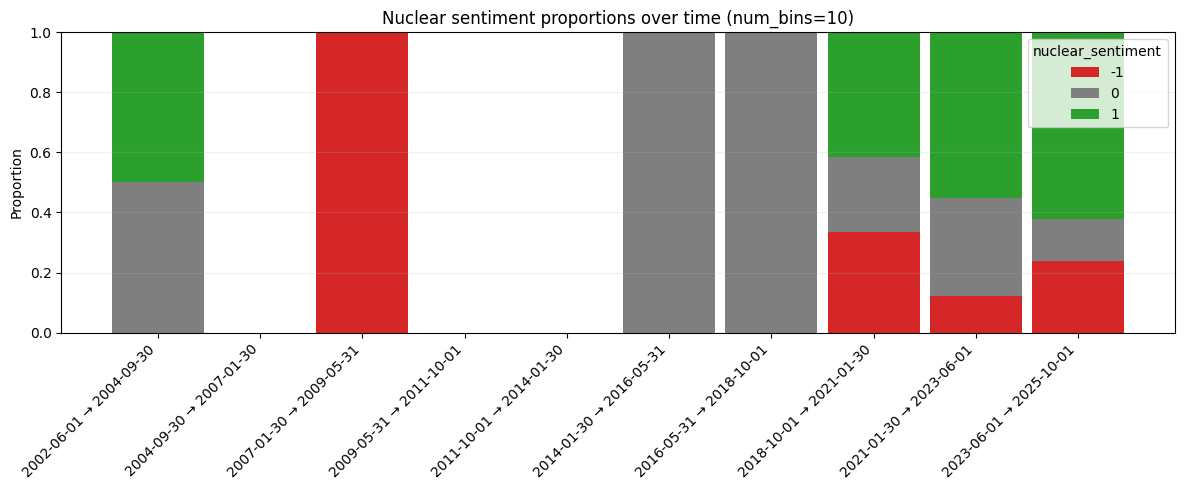

In [6]:
# Plot: stacked proportions per bucket
fig, ax = plt.subplots(figsize=(12, 5))

colors = {
    -1: "#d62728",  # red
    0: "#7f7f7f",   # gray
    1: "#2ca02c",   # green
}

bottom = np.zeros(len(props))
xpos = np.arange(len(props))

for s in sentiment_order:
    ax.bar(xpos, props[s].values, bottom=bottom, color=colors[s], label=str(s), width=0.9)
    bottom += props[s].values

ax.set_title(f"Nuclear sentiment proportions over time (num_bins={num_bins})")
ax.set_ylabel("Proportion")
ax.set_ylim(0, 1)
ax.set_xticks(xpos)
ax.set_xticklabels([str(x) for x in props.index], rotation=45, ha="right")
ax.legend(title="nuclear_sentiment")
ax.grid(axis="y", alpha=0.2)

plt.tight_layout()
plt.show()

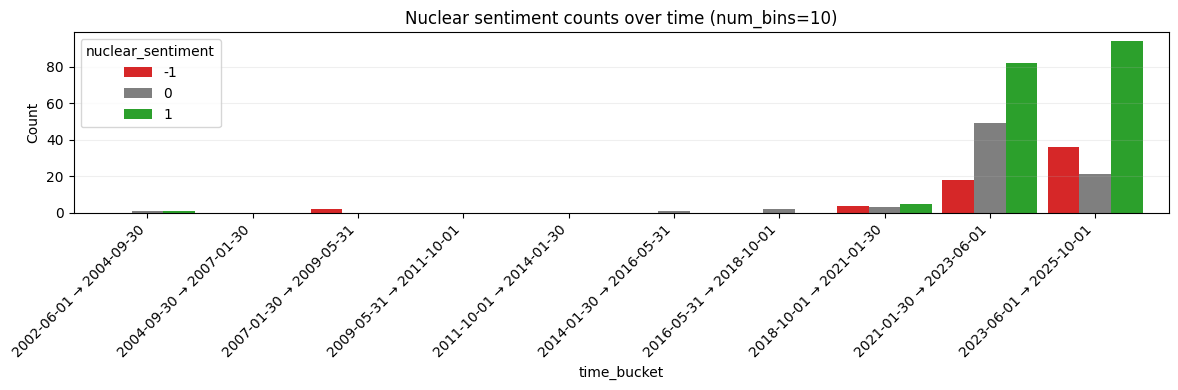

In [7]:
# (Optional) Also show raw counts
counts.plot(kind="bar", figsize=(12, 4), color=["#d62728", "#7f7f7f", "#2ca02c"], width=0.9)
plt.title(f"Nuclear sentiment counts over time (num_bins={num_bins})")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()